# CASA0007 QUANTITATIVE METHODS - COURSEWORK 3

Title: How does Urban Greenery Affect Personal Well-Being in London?

Abstract: This paper investigates the effect of urban greenery on personal well-being in London and the associated pathway(s) by answering the following research questions:
- Does urban greenery affect personal well-being, as measured by ONS4?
- What is the pathway(s) by which urban greenery affect personal well-being?

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from math import log, sqrt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA 
from scipy.stats import norm

## Presentation of Data

### Personal Well-Being

In [2]:
# Read well-being
# Source: https://data.london.gov.uk/dataset/subjective-personal-well-being-borough
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/personal-well-being-borough.xlsx?raw=true'
wellbeing = pd.read_excel(url, sheet_name = 'Summary - Mean Scores', skiprows = 1)

# Rename and keep useful columns
wellbeing_cols = ['Life Satisfaction', 'Worthwhile', 'Happiness']
year = '2011/12'
wellbeing.rename({year: wellbeing_cols[0],
                 year+'.1': wellbeing_cols[1],
                 year+'.2': wellbeing_cols[2],
                 year+'.3': 'Anxiety'},
                axis = 1, inplace = True)
wellbeing = wellbeing[['Code', 'Area'] + wellbeing_cols + ['Anxiety']]

# Keep only data on London boroughs (Area Code starts with E09)
wellbeing.dropna(axis = 0, inplace = True)
wellbeing.drop(wellbeing[wellbeing.Area == "City of London"].index, inplace = True)
wellbeing = wellbeing[wellbeing['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
wellbeing = wellbeing.reset_index(drop = True)
wellbeing.drop('Code', axis = 1, inplace = True)

# Set data type
wellbeing[wellbeing_cols + ['Anxiety']] = wellbeing[wellbeing_cols + ['Anxiety']].astype('float', copy = False)

### Urban Greenery

In [3]:
# Read NDVI
# Source: https://data.london.gov.uk/dataset/green-and-blue-cover
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/green_cover_borough_summary_0.05.xlsx?raw=true'
ndvi_cols = ['lb_code', 'lb_name', 'percent_green']
ndvi = pd.read_excel(url, sheet_name = 'borough_green_cover', usecols = ndvi_cols)

# Drop City of London
ndvi.drop(ndvi[ndvi.lb_code == 'City of London'].index, inplace = True)
ndvi.sort_values(by = ['lb_name'], ascending=True)
ndvi = ndvi.reset_index(drop = True)

# Change name of 'City of Westminster' to Westminster
ndvi.loc[ndvi[ndvi.lb_code == 'City of Westminster'].index, 'lb_code'] = 'Westminster'

# Rename column
ndvi.drop('lb_name', axis = 1, inplace = True)
ndvi.rename({'lb_code': 'Area', 
             'percent_green': 'percentage_greenery'}, axis = 1, inplace = True)

### Mediators

#### Intrinsic well-being enhancement quality of greenery

In [4]:
anxiety = wellbeing.drop(wellbeing_cols, axis = 1)
anxiety.Anxiety = -anxiety.Anxiety
wellbeing.drop('Anxiety', axis = 1, inplace = True)

#### Promotion of physical activities

In [5]:
# Read in physical exercise
# Source: https://data.londonsport.org/dataset/e53dn/physical-activity-levels-by-borough
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/LSD21-APS-Physical-Activity-Levels.xlsx?raw=true'
exercise = pd.read_excel(url, sheet_name = '2012', usecols = ['GSS_Code', 'Region', 'Active'])

# Keep only data on London boroughs (Area Code starts with E09)
exercise = exercise[exercise['GSS_Code'].str.match(r'E09')].sort_values(by = ['GSS_Code'], ascending=True)
exercise = exercise.reset_index(drop = True)
exercise.drop('GSS_Code', axis = 1, inplace = True)

# Convert 'Active' to percentage
exercise.Active = exercise.Active*100

# Rename columns
exercise.rename({'Region': 'Area'}, axis = 1, inplace = True)

#### Enhancement of air quality

In [6]:
# Read in air quality 
# Source: https://data.london.gov.uk/dataset/llaqm-bespoke-borough-by-borough-air-quality-modelling-and-data
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/NO2_AnnualMean_2013_PopulationData.xlsx?raw=true'
air_quality = pd.read_excel(url, sheet_name = 'Borough exceeding 40', skiprows = 4, 
                            usecols=['Borough Name', 'PopExc2013 %'])
air_quality['Borough Name'] = air_quality['Borough Name'].str.replace('&', 'and')

# Drop City of London
air_quality.drop(air_quality[air_quality['Borough Name'] == 'City of London'].index, inplace = True)
air_quality = air_quality.reset_index(drop = True)

# Log
air_quality['air_quality'] = -air_quality['PopExc2013 %'].apply(log)
air_quality.drop('PopExc2013 %', axis = 1, inplace = True)

# Rename columns
air_quality.rename({'Borough Name': 'Area'},
                  axis = 1, inplace = True)

### Control Variables

#### Self-reported health and age

In [7]:
# Read self-reported health and age profile 
# Source: https://data.london.gov.uk/dataset/msoa-atlas
url = 'https://raw.githubusercontent.com/ngliangwei15/CASA0007-CW3/main/Data/msoa-data.csv'
age_cols = ['Age Structure (2011 Census);0-15;',
            'Age Structure (2011 Census);16-29;',
            'Age Structure (2011 Census);30-44;',
            'Age Structure (2011 Census);45-64;',
            'Age Structure (2011 Census);65+;']
health_cols = ['Health (2011 Census);Very good health;',
              'Health (2011 Census);Good health;',
              'Health (2011 Census);Fair health;',
              'Health (2011 Census);Bad health;',
              'Health (2011 Census);Very bad health;']
age_health = pd.read_csv(url,
                         usecols = ['Middle Super Output Area', 'MSOA Name',
                                    'Age Structure (2011 Census);All Ages;'] + age_cols + health_cols, 
                         low_memory = False, encoding = 'latin')

# Drop row on average for London and City of London
age_health.dropna(axis = 0, inplace = True)
age_health.drop(age_health[age_health['MSOA Name'] == 'City of London 001'].index, inplace = True)
age_health.reset_index(inplace = True)

# Change data type
age_health[age_cols] = age_health[age_cols].astype('int', copy = False)
age_health[health_cols] = age_health[health_cols].astype('int', copy = False)

# Drop numbers (last 4 characters) from MSOA name
for i in range(0, age_health.shape[0]):
               age_health.iloc[i,2] = age_health.iloc[i,2][:-4]

# Compute total number of respondents in MSOA
respondents = age_health.groupby('MSOA Name').agg({'Age Structure (2011 Census);All Ages;': np.sum}).reset_index()

# Compute number and percentage of respondents in each age group
age = age_health.groupby('MSOA Name').agg(dict.fromkeys(age_cols, np.sum)).reset_index()
age[age_cols] = age[age_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Compute number and percentage of respondents in each health category
health = age_health.groupby('MSOA Name').agg(dict.fromkeys(health_cols, np.sum)).reset_index()
health[health_cols] = health[health_cols].div(respondents['Age Structure (2011 Census);All Ages;'], axis = 0) * 100

# Rename columns for easy reference
age.rename({age_cols[0]: 'Age_0-15',
           age_cols[1]: 'Age_15-29',
           age_cols[2]: 'Age_30-44',
           age_cols[3]: 'Age_45-64',
           age_cols[4]: 'Age_65+',
           'MSOA Name': 'Area'},
          axis = 1, inplace = True)
health.rename({health_cols[0]: 'Health_Very_good',
               health_cols[1]: 'Health_Good',
               health_cols[2]: 'Health_Fair',
               health_cols[3]: 'Health_Bad',
               health_cols[4]: 'Health_Very_bad',
              'MSOA Name': 'Area'},
              axis = 1, inplace = True)

#### Economic Activity

In [8]:
# Read economic inactivity and rename columns for easy reference
# Source: https://data.london.gov.uk/dataset/economic-inactivity-gender
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/economic-inactivity.csv?raw=true'
econ_cols = ['Code', 'Area', 'percent; Jan 2011-Dec 2011']
economic = pd.read_csv(url, usecols = econ_cols, low_memory = False, encoding = 'latin')
economic.rename({econ_cols[2]: 'Economic_Inactive'}, axis = 1, inplace = True)

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
economic.dropna(axis = 0, inplace = True)
economic = economic[economic['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
economic.drop(economic[economic.Area == 'City of London'].index, inplace = True)
economic = economic.reset_index(drop = True)
economic.drop('Code', axis = 1, inplace = True)

# Change data type
economic.Economic_Inactive = economic.Economic_Inactive.astype('float', copy = False)

In [9]:
# Read unemployment rate
# Source: https://data.london.gov.uk/dataset/employment-occupation-type-and-gender-borough
url = 'https://github.com/ngliangwei15/CASA0007-CW3/blob/main/Data/mb-unemployment-rates.xlsx?raw=true'
unemployment_cols = ['Code', 'Area', 'Jan 2011-Dec 2011']
unemployment = pd.read_excel(url, usecols = unemployment_cols, sheet_name = 'Rates')

# Keep only data on London boroughs (Area Code starts with E09), drop City of London and change data type
unemployment.dropna(axis = 0, inplace = True)
unemployment = unemployment[unemployment['Code'].str.match(r'E09')].sort_values(by = ['Code'], ascending=True)
unemployment.drop(unemployment[unemployment.Area == 'City of London'].index, inplace = True)
unemployment = unemployment.reset_index(drop = True)

# Change data type
unemployment['Jan 2011-Dec 2011'] = unemployment['Jan 2011-Dec 2011'].astype('float', copy = False)

In [10]:
# Compute unemployment rate among economically active
economic['Economic_Unemployed'] = ((100 - economic.Economic_Inactive)/100) * (unemployment['Jan 2011-Dec 2011']/100) * 100

# Compute employment rate among economically active
economic['Economic_Employed'] = 100 - economic.Economic_Inactive - economic.Economic_Unemployed

### Descriptive Statistics

In [11]:
# Create dictionary of variable names
dataset = {'dependent': ['wellbeing'], 
           'independent': ['ndvi'], 
           'mediators': ['anxiety', 'exercise', 'air_quality'], 
           'control': ['health', 'economic', 'age']}

# Initialize dataframe
data_descriptive = pd.DataFrame(globals()[dataset[[*dataset][0]][0]].Area)

# Merge data
for value in dataset.values():
    for var in value:
        data_descriptive = data_descriptive.merge(globals()[var], on = 'Area')
        
# Descriptive statistics
data_descriptive.describe()

,Life Satisfaction,Worthwhile,Happiness,percentage_greenery,Anxiety,Active,air_quality,Health_Very_good,Health_Good,Health_Fair,Health_Bad,Health_Very_bad,Economic_Inactive,Economic_Unemployed,Economic_Employed,Age_0-15,Age_15-29,Age_30-44,Age_45-64,Age_65+
count,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,7.258125,7.515313,7.196875,44.802959,-3.408125,56.646875,-2.089631,50.737407,33.179188,11.131793,3.729020,1.222592,25.618750,6.912775,67.468475,19.725082,22.477956,25.436773,21.230973,11.129217
std,0.161034,0.168771,0.137617,11.010521,0.299402,4.783101,1.409677,3.291963,2.159292,1.108135,0.546002,0.250549,4.362778,1.510814,4.946267,2.400514,4.075104,2.788041,2.857208,2.859348
min,7.000000,7.140000,6.910000,25.381534,-3.890000,47.900000,-4.437235,46.001804,28.483634,8.892327,2.469116,0.751912,18.200000,3.720000,55.341000,14.851684,15.407241,19.512123,13.853032,6.127605
25%,7.117500,7.367500,7.097500,38.511252,-3.545000,53.625000,-3.168913,48.112261,31.102858,10.412260,3.430292,1.088244,22.400000,5.776575,63.411625,18.662404,20.127883,23.289848,19.517624,8.939003
50%,7.255000,7.545000,7.200000,43.412392,-3.435000,55.600000,-1.840001,49.856985,33.668575,11.277400,3.750597,1.198700,24.650000,6.879200,67.659100,20.134199,21.621243,25.630995,21.242347,10.792873
75%,7.382500,7.645000,7.272500,53.105374,-3.282500,60.475000,-1.338607,52.740271,34.990509,11.814429,4.117947,1.387229,28.150000,8.270100,71.827350,20.783955,26.297520,27.880288,22.927577,12.749657
max,7.570000,7.840000,7.490000,68.356138,-2.650000,67.400000,0.805629,57.840894,36.003698,13.274769,4.740327,1.684900,35.500000,9.282000,76.015500,25.979098,32.640419,30.555221,26.309267,17.820952


## Step 1: Establish the effect of the independent variable on the dependent variables 

### Step 1a: Linear regressions of dependent variables on the independent variable

PERFORMING REGRESSION ON:LIFE SATISFACTION
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     4.531
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0416
Time:                        17:51:27   Log-Likelihood:                 15.789
No. Observations:                  32   AIC:                            -27.58
Df Residuals:                      30   BIC:                            -24.65
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

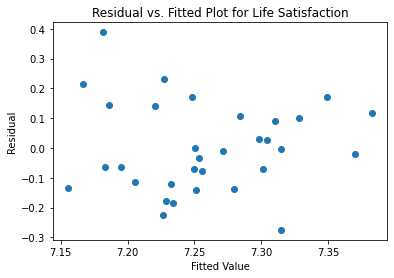



PERFORMING REGRESSION ON:WORTHWHILE
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     13.24
Date:                Mon, 17 Jan 2022   Prob (F-statistic):            0.00102
Time:                        17:51:27   Log-Likelihood:                 17.885
No. Observations:                  32   AIC:                            -31.77
Df Residuals:                      30   BIC:                            -28.84
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

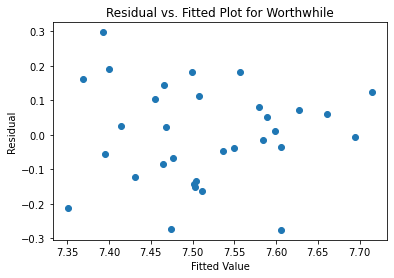



PERFORMING REGRESSION ON:HAPPINESS
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     3.822
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0599
Time:                        17:51:27   Log-Likelihood:                 20.486
No. Observations:                  32   AIC:                            -36.97
Df Residuals:                      30   BIC:                            -34.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

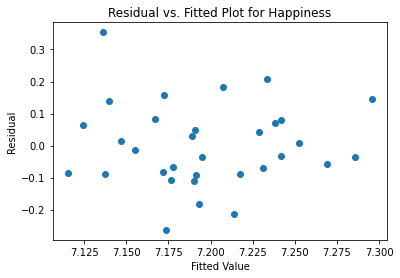

In [12]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')
ind_var = ndvi.columns.tolist()[1:]

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(data[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

Urban greenery had positive effect on all three aspects of well-being, but were significant for LS and WW only.

### Step 1(b): Control variables were added to the regressions as additional independent variables.

In [13]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')
data = data.merge(health, on = 'Area')
data = data.merge(economic, on = 'Area')
data = data.merge(age, on = 'Area')

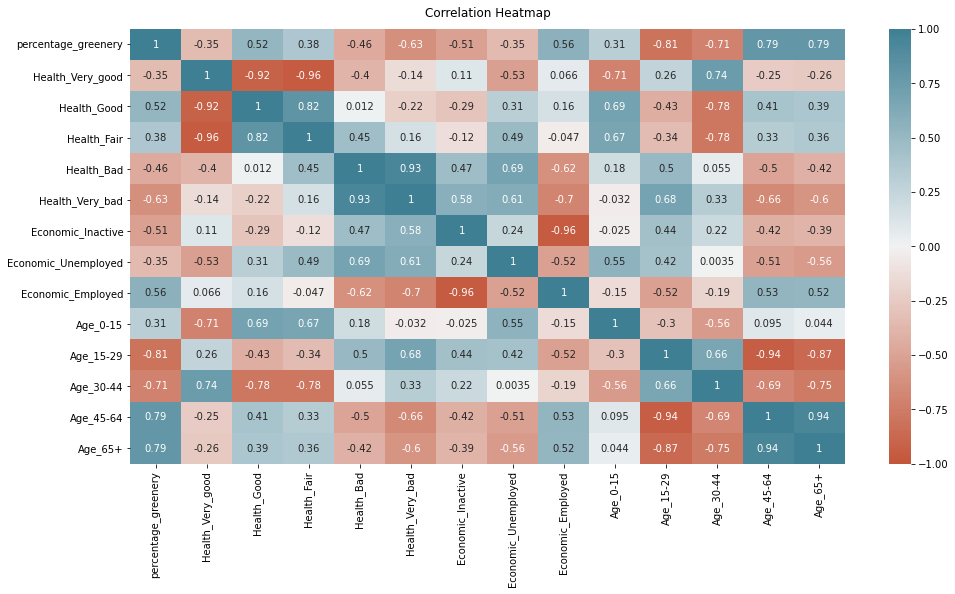

In [14]:
# Visualize collinearity
df = data.drop(['Area'] + wellbeing.columns.tolist(), axis = 1)
plt.figure(figsize=(16, 8))
cm = sns.diverging_palette(20, 220, as_cmap=True)
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap = cm, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

#### (i) Using VIF to handle multi-collinearity

In [15]:
# Define function to drop variables using VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constant item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [16]:
# Drop collinear variables
ind_var_data = drop_column_using_vif_(df)

# Variable names of remaining variables
ind_var = ind_var_data.columns.tolist()

Dropping: Health_Very_good
Dropping: Economic_Inactive
Dropping: Age_0-15
Dropping: Health_Bad
Dropping: Age_65+
Dropping: Health_Fair
Dropping: Age_45-64


/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1738: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/opt/conda/envs/sds2021/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


PERFORMING REGRESSION ON:LIFE SATISFACTION
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     8.649
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           2.70e-05
Time:                        17:51:28   Log-Likelihood:                 33.686
No. Observations:                  32   AIC:                            -51.37
Df Residuals:                      24   BIC:                            -39.65
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

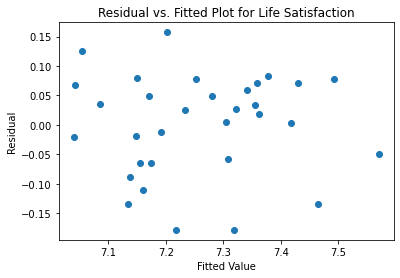



PERFORMING REGRESSION ON:WORTHWHILE
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     8.411
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           3.37e-05
Time:                        17:51:28   Log-Likelihood:                 31.866
No. Observations:                  32   AIC:                            -47.73
Df Residuals:                      24   BIC:                            -36.01
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

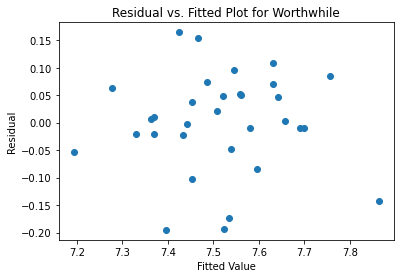



PERFORMING REGRESSION ON:HAPPINESS
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     2.395
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0522
Time:                        17:51:28   Log-Likelihood:                 27.043
No. Observations:                  32   AIC:                            -38.09
Df Residuals:                      24   BIC:                            -26.36
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

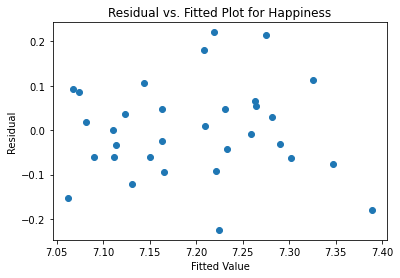

In [17]:
# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(data[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

Urban greenery no longer had a significant effect on well-being, when other variables are controlled for.

#### (i) Using PCA to handle collinearity

In [18]:
# Merge data of independent and control variables
data_pca = pd.merge(ndvi, health, on = 'Area')
data_pca = data_pca.merge(economic, on = 'Area')
data_pca = data_pca.merge(age, on = 'Area')

# Standardize data
cols = data_pca.columns.tolist()[1:]
scalers = [StandardScaler().fit(data_pca[x].values.reshape(-1,1)) for x in cols]
data_tr = data_pca.copy()
for i in range(0, len(cols)):
    data_tr.loc[:,cols[i]] = scalers[i].transform(data_tr[cols[i]].values.reshape(-1,1))

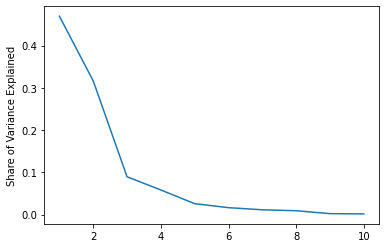

Component  0 accounts for 46.93% of variance
Component  1 accounts for 31.62% of variance
Component  2 accounts for 8.94% of variance
Component  3 accounts for 5.82% of variance
Component  4 accounts for 2.58% of variance
Component  5 accounts for 1.64% of variance
Component  6 accounts for 1.13% of variance
Component  7 accounts for 0.91% of variance
Component  8 accounts for 0.22% of variance
Component  9 accounts for 0.16% of variance


In [19]:
# Perform PCA
pca = PCA(n_components=10, whiten=True) 
pca.fit(data_tr[cols])

# Check the variance
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

# Plot variance
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.ylabel('Share of Variance Explained')
plt.show()

for i in range(0, 10):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

In [20]:
# The first four components explain 93.31% of the variance. Hence, we will proceed with 4 components 

keep_n_components = 4
pca = PCA(n_components=keep_n_components, whiten=True)

data_tr_pca = pca.fit_transform(data_tr[cols])

In [21]:
# Merge back with dataframe

for x in [data_tr_pca]:
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])

    for i in range(0,keep_n_components):
        data_pca[f"Component_{i+1}"] = new_columns[i]

In [22]:
# Eigenvectors
eig_vec = pca.components_
eig_vec_table = pd.DataFrame(cols, columns = ['Indepdendent Variable'])
eig_vec_table = eig_vec_table.join(pd.DataFrame(eig_vec).transpose())
eig_vec_table = eig_vec_table.rename({0: 'PC1', 1: 'PC2', 2: 'PC3', 3: 'PC4'}, axis = 1)

cm = sns.diverging_palette(20, 220, as_cmap=True)
x=eig_vec_table.style.background_gradient(cmap=cm)
display(x)

,Indepdendent Variable,PC1,PC2,PC3,PC4
0,percentage_greenery,-0.349875,-0.000405,-0.050224,-0.029411
1,Health_Very_good,0.163377,0.417756,-0.083235,-0.097067
2,Health_Good,-0.245123,-0.314810,0.169851,-0.132851
3,Health_Fair,-0.175668,-0.408124,-0.003843,0.232461
4,Health_Bad,0.207130,-0.335200,-0.105698,0.456114
5,Health_Very_bad,0.291481,-0.240251,-0.122860,0.398197
6,Economic_Inactive,0.242273,-0.120279,-0.611081,-0.299408
7,Economic_Unemployed,0.151865,-0.378535,0.281361,-0.115052
8,Economic_Employed,-0.260080,0.221712,0.453054,0.299230
9,Age_0-15,-0.124783,-0.347434,0.154591,-0.532667


Urban greenery was highly loaded in PC1.

In [23]:
# Prepare data for regression
data_pca.drop(['Health_Very_good', 'Health_Good', 'Health_Fair', 'Health_Bad', 'Health_Very_bad', 
               'Age_0-15', 'Age_15-29', 'Age_30-44', 'Age_45-64', 'Age_65+', 
               'Economic_Inactive', 'Economic_Unemployed', 'Economic_Employed', 
               'percentage_greenery'], axis = 1, inplace = True)

# Merge data
data_reg = wellbeing.merge(data_pca, on = 'Area')

PERFORMING REGRESSION OF LIFE SATISFACTION
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     15.97
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           8.05e-07
Time:                        17:51:29   Log-Likelihood:                 32.955
No. Observations:                  32   AIC:                            -55.91
Df Residuals:                      27   BIC:                            -48.58
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const  

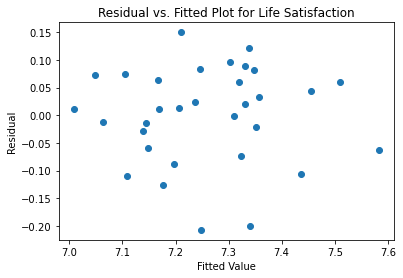



PERFORMING REGRESSION OF WORTHWHILE
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     11.43
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           1.48e-05
Time:                        17:51:29   Log-Likelihood:                 27.887
No. Observations:                  32   AIC:                            -45.77
Df Residuals:                      27   BIC:                            -38.44
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       

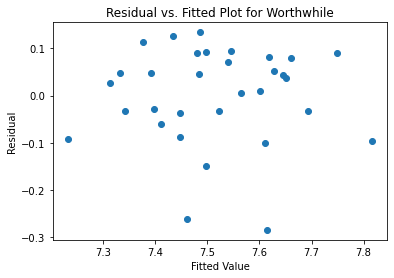



PERFORMING REGRESSION OF HAPPINESS
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     4.635
Date:                Mon, 17 Jan 2022   Prob (F-statistic):            0.00560
Time:                        17:51:29   Log-Likelihood:                 26.931
No. Observations:                  32   AIC:                            -43.86
Df Residuals:                      27   BIC:                            -36.53
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        

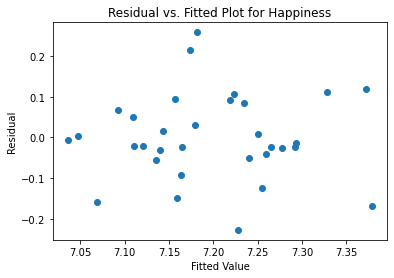

In [24]:
# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION OF {cat.upper()}')
    
    # Perform regression
    reg_model = sm.OLS(endog=data_reg[cat], exog=sm.add_constant(data_reg[data_reg.columns.tolist()[4:]])).fit()
    #reg_model = back_regress(data_reout[cat], data_reout[group])
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')

PC1, which was negatively related to urban greenery, had a negative relationship with all aspects of well-being, and this was significant for LS and WW, like the observation in step 1(a).

## Step 2: Establish the effect of urban greenery on the mediators

In [25]:
# Initialize dataframe to track coefficient and standard error
path_a = pd.DataFrame({'Mediators': dataset['mediators'], 
                       'Coeff_a': [0] * len(dataset['mediators']),
                       'se_a': [0] * len(dataset['mediators'])})

PERFORMING REGRESSION OF ANXIETY
                            OLS Regression Results                            
Dep. Variable:                Anxiety   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7343
Date:                Mon, 17 Jan 2022   Prob (F-statistic):              0.398
Time:                        17:51:29   Log-Likelihood:                -5.9201
No. Observations:                  32   AIC:                             15.84
Df Residuals:                      30   BIC:                             18.77
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
c

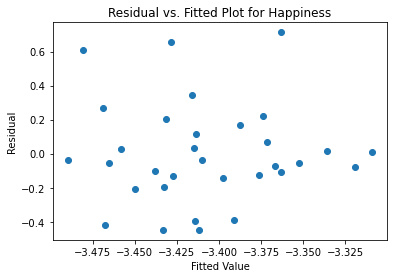



PERFORMING REGRESSION OF EXERCISE
                            OLS Regression Results                            
Dep. Variable:                 Active   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                 9.029e-05
Date:                Mon, 17 Jan 2022   Prob (F-statistic):              0.992
Time:                        17:51:29   Log-Likelihood:                -94.981
No. Observations:                  32   AIC:                             194.0
Df Residuals:                      30   BIC:                             196.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

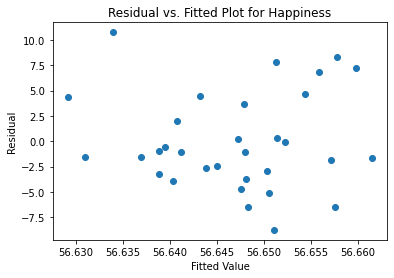



PERFORMING REGRESSION OF AIR_QUALITY
                            OLS Regression Results                            
Dep. Variable:            air_quality   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     17.60
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           0.000223
Time:                        17:51:29   Log-Likelihood:                -48.499
No. Observations:                  32   AIC:                             101.0
Df Residuals:                      30   BIC:                             103.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

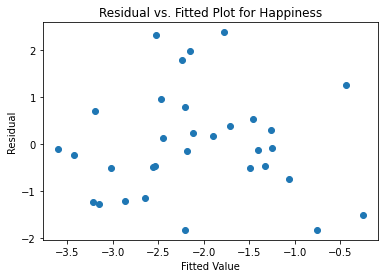

In [26]:
# Get exogeneous variable
exog = globals()[dataset['independent'][0]]

# Perform regression
for mediator in dataset['mediators']:
    print(f'PERFORMING REGRESSION OF {mediator.upper()}')

    # Get endogeneous variable
    endog = globals()[mediator]
    
    # Merge data
    data_reg = pd.merge(endog, exog, on = 'Area')
    
    # Perform regression
    reg_model = sm.OLS(endog= data_reg[endog.columns.tolist()[1:]], 
                       exog=sm.add_constant(data_reg[exog.columns.tolist()[1:]])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')
    
    # Store results
    path_a.loc[path_a.Mediators == mediator, 'Coeff_a'] = reg_model.params[1]
    path_a.loc[path_a.Mediators == mediator, 'se_a'] = reg_model.bse[1]

Urban greenery had a positive and significant effect on air quality, but no significant effect on the other two mediators. Hence, testing for the effect of the mediators on well-being proceeded for enhancement of air quality only.

## Step 3: Establish the effect of the mediators, which were established to be significantly affected by urban greenery, on personal well-being 

In [27]:
# Initialize dataframe to track coefficient and standard error
path_b = pd.DataFrame({'Aspect': wellbeing_cols, 
                       'Coeff_b': [0] * len(wellbeing_cols),
                       'se_b': [0] * len(wellbeing_cols)})

PERFORMING REGRESSION ON:LIFE SATISFACTION
                            OLS Regression Results                            
Dep. Variable:      Life Satisfaction   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     5.225
Date:                Mon, 17 Jan 2022   Prob (F-statistic):             0.0115
Time:                        17:51:29   Log-Likelihood:                 18.462
No. Observations:                  32   AIC:                            -30.92
Df Residuals:                      29   BIC:                            -26.53
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

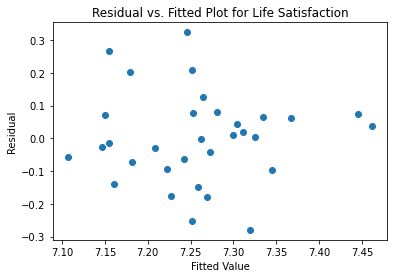



PERFORMING REGRESSION ON:WORTHWHILE
                            OLS Regression Results                            
Dep. Variable:             Worthwhile   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     6.871
Date:                Mon, 17 Jan 2022   Prob (F-statistic):            0.00361
Time:                        17:51:29   Log-Likelihood:                 18.243
No. Observations:                  32   AIC:                            -30.49
Df Residuals:                      29   BIC:                            -26.09
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

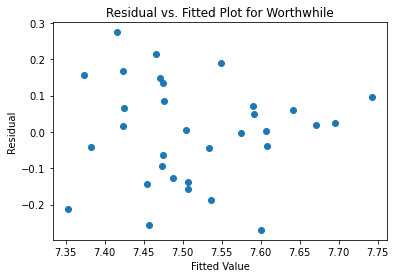



PERFORMING REGRESSION ON:HAPPINESS
                            OLS Regression Results                            
Dep. Variable:              Happiness   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.407
Method:                 Least Squares   F-statistic:                     11.66
Date:                Mon, 17 Jan 2022   Prob (F-statistic):           0.000192
Time:                        17:51:29   Log-Likelihood:                 28.008
No. Observations:                  32   AIC:                            -50.02
Df Residuals:                      29   BIC:                            -45.62
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

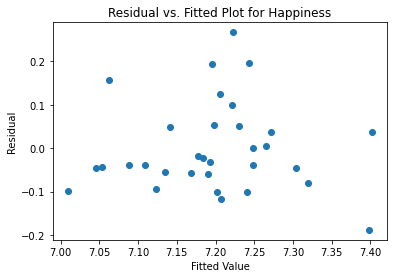

In [28]:
# Merge data
data = pd.merge(wellbeing, ndvi, on = 'Area')
data = data.merge(air_quality, on = 'Area')
ind_var = data.columns.tolist()[4:]

# Perform regression
for cat in wellbeing_cols:
    print(f'PERFORMING REGRESSION ON:{cat.upper()}')

    # Perform regression
    reg_model = sm.OLS(endog=data[cat], exog=sm.add_constant(data[ind_var])).fit()
    print(reg_model.summary())

    # plot residual vs. fit
    plt.scatter(reg_model.fittedvalues, reg_model.resid)
    plt.xlabel('Fitted Value')
    plt.ylabel('Residual')
    plt.title('Residual vs. Fitted Plot for ' + cat.title())
    plt.show()
    print('\n')
    
    # Store results
    path_b.loc[path_b.Aspect == cat, 'Coeff_b'] = reg_model.params[2]
    path_b.loc[path_b.Aspect == cat, 'se_b'] = reg_model.bse[2]

#### Sobel test

In [29]:
# Create dataframe
sobel = pd.DataFrame({'Aspect': wellbeing_cols, 
                       'Coeff_a': path_a.loc[path_a.Mediators == 'air_quality', 'Coeff_a'].tolist() * len(wellbeing_cols),
                       'se_a': path_a.loc[path_a.Mediators == 'air_quality', 'se_a'].tolist() * len(wellbeing_cols)})
sobel = sobel.merge(path_b, on = 'Aspect')

# Compute Z-statistics and p-value
sobel['Z-stat'] = (sobel.Coeff_a * sobel.Coeff_b) / (
    (((sobel.Coeff_a**2) * (sobel.se_b**2)) + ((sobel.Coeff_b**2) * (sobel.se_a**2))).apply(sqrt))
sobel['p-value'] = norm.cdf(sobel['Z-stat'])

# Display values
sobel

,Aspect,Coeff_a,se_a,Coeff_b,se_b,Z-stat,p-value
0,Life Satisfaction,0.077854,0.018557,-0.052613,0.022910,-2.014443,0.021982
1,Worthwhile,0.077854,0.018557,-0.018680,0.023068,-0.795111,0.213275
2,Happiness,0.077854,0.018557,-0.070930,0.017001,-2.958362,0.001546


Enhancement of air quality was a significant mediator between urban greenery, and LS and HP. While urban greenery had a positive relationship on both air quality and well-being, there was a negative relationship between air quality and well-being.